# Overfitting and Early Stopping

## Introduction

In previous lessons, we have seen that decision trees choose features that split our data into different groups of target variables.  For example, when we look at the decision tree for customer leads, our tree perfectly segments our dataset between customers and non-customers.

![](DTreeViz_customers.svg)

In this lesson, we'll see how decision trees can segment our data a little too well.  That is, we'll learn one way that decision trees are prone to overfitting.

## Working with the diabetes dataset

For this lesson, let's work with the diabetes dataset provided with sklearn.

In [3]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
dataset = load_diabetes()
X = dataset['data']
y = dataset['target']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

The following information about the training and target data is provided. 

> **Target:** A quantitative measure of disease progression one year after baseline

> **Attribute Information**
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

In [4]:
X_train.shape

(296, 10)

So we have ten features and close to 300 observations.

## Training our decision tree

Now let's train our decision tree and see how it performs.

In [5]:
from sklearn.tree import DecisionTreeRegressor
dtc = DecisionTreeRegressor()
dtc.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [6]:
dtc.score(X_train, y_train)

1.0

Look at the score above, our first perfectly fit model.  Of course, what really matters is how well our decision tree performs on data it has not yet seen.

In [7]:
dtc.score(X_test, y_test)

-0.08331039544463636

Oops.

Here is just a small portion of the decision tree that was created above.

![](./d-tree.png)

Notice that at the bottom layer of decision tree we have a lot of leaves, each with a sample size of just one.  

* So our decision tree is able to perfectly fit our data.  
* But in most if not all of the occurrences, it's prediction is based on a sample size of one.

### Correcting for Overfitting

So now we can better understand how our decision tree overfits to the training data.  It overfits because each time a prediction contain any error, our decision tree simply tries another split. At a certain point, the tree is no longer fitting to the pattern in the data, but on the data's random variation.  In the decision tree above, we would have done a better job predicting if we had just predicted the mean.

One way to correct for this overfitting is to use early stopping.  This prevents our the leaves of a decision tree from having a separate leaf for each datapoint.  Rather we can require each leaf to have multiple datapoints.

1. We can define the number of layers we train for our decision tree.  
2. Or we can simply define the number of samples a node must have for our decision tree to continue splitting

Notice that each accomplishes the same thing: the more samples we require in our leaf nodes, the fewer the levels of our tree. To see this, consider two extremes:

* If we set `min_samples_leaf` to $\frac{1}{2}$ the size of our dataset, our tree would only have one split, and two leaves.
* Or, in the opposite case, if we have just one sample per leaf, our tree would require a large number of levels to split the data into samples of one. 

### Setting parameters in SKLearn

The technique we learned above is called *early stopping*.  We can accomplish early stopping in `sklearn` by initializing our tree with either a `max_depth` parameter or a `min_samples_leaf` parameter.

In [12]:
# DecisionTreeRegressor(min_samples_leaf=1, max_depth=1)

Let's work with our `min_samples_leaf` feature.  

And in doing so, let's tackle the next question: how do we know the correct number to use for max depth?  Here's a hint: `min_samples_leaf` is a hyperparameter.

Because `min_samples_leaf` is just a hyperparameters, we use our technique of trying various values for the hyperparameter and scoring the performance of our models against the holdout set.  Let's do it.

In [9]:
import numpy as np
num_sample_scores = []
for sample in range(1, 100):
    dtc = DecisionTreeRegressor(min_samples_leaf=sample)
    dtc.fit(X_train, y_train)
    score = dtc.score(X_test, y_test)
    num_sample_scores.append(np.array([sample, score]))
    
num_sample_scores = np.array(num_sample_scores)

Above, we created a matrix that has a column of indicating the parameter for `min_samples_leaf` and another column with the score of the related decision tree.

In [10]:
num_sample_scores[:3]

array([[ 1.        , -0.13351581],
       [ 2.        , -0.01357229],
       [ 3.        , -0.00320926]])

Ok, let's plot all of the scores to see how `min_samples_leaf` reduces overfitting in our decision tree.

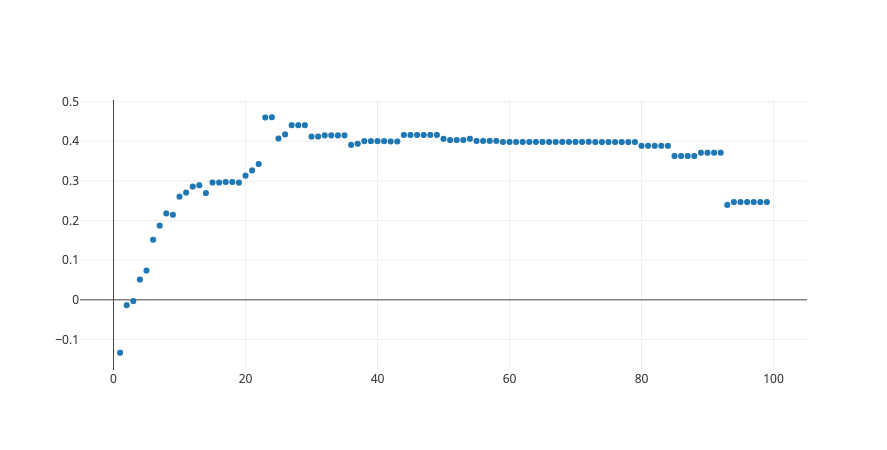

In [11]:
from graph import trace_values, plot
trace = trace_values(num_sample_scores[:, 0], num_sample_scores[:, 1])
plot([trace])

In the above graph, we are seeing our bias-variance tradeoff at work.  Remember that our models become simpler as we have a larger `min_sample_leaf` -- these are the models with fewer splits.  So the fewer the number of splits, the smaller the variance as there are more samples in each leaf, and thus the prediction is less sensitive to the varitation in the datapoints.  But for this same reason, the simpler model is more biased.  

From the graph above, it seems a `min_samples_leaf` of 24 does the best job of balancing our bias variance tradeoff.

So fitting our decision tree with this hyperparameter we find the following.

In [13]:
dtc = DecisionTreeRegressor(min_samples_leaf=25)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.4068802443937598

Let's view the tree.

from sklearn import tree
from IPython.display import SVG, display
from graphviz import Source 


graph_1 = Source(tree.export_graphviz(dtc, out_file=None,
                                feature_names=dataset['feature_names']))

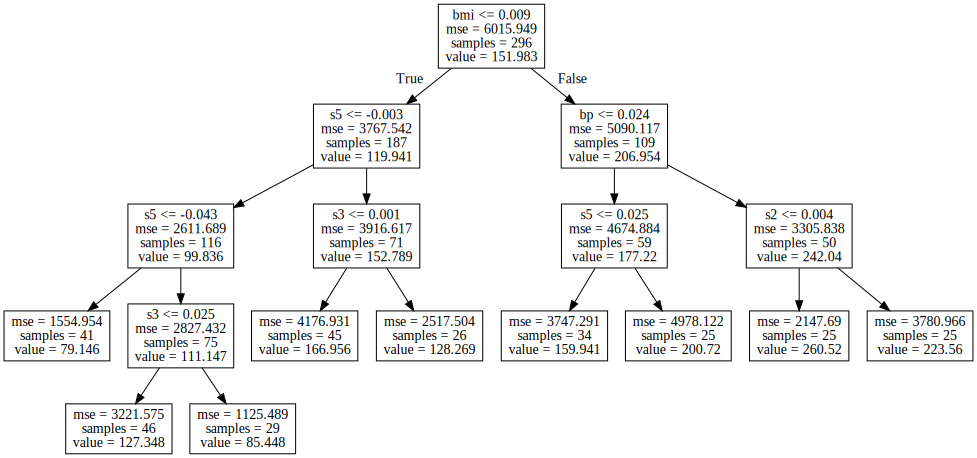

In [16]:
graph_1

Here, we can see that our tree is much simpler than our unbounded tree.  And it also scores higher on our test set.

### Summary

In this lesson, we saw overfitting in decision trees.  Decision trees are highly flexible, allowing decision trees to closely match any data.  This is useful when decision trees are responding to underlying patterns in the data, but makes them prone to overfitting as they are also flexible enough to respond to pure noise.

The number of datapoints in our leaf nodes influences the flexibility of our decision trees.  Without a minimum sample size on our leaf nodes, our tree makes a separate prediction based on a sample size of just one datapoint.  To correct for this, we can assign a `min_samples_leaf` parameter.  

We chose the value of this parameter the same way that we chose other hyperparameters, by trying different numbers and assessing the respective model's performance against the holdout set.  We then chose the hyperparameter that had the highest accuracy on our holdout set.